In [ ]:
!pip install qiskit
!pip install qiskit_aer
!pip install qiskit_ibm_runtime
!pip install pylatexenc

In [ ]:
# configure backend
import qiskit
import pylatexenc
from qiskit_ibm_runtime import QiskitRuntimeService

service = QiskitRuntimeService(channel = "ibm_quantum", #ibm cloud
                               token = "7a31b765e519ab16da85b8d03351b980388901e70cb1170057c90c1c7fda8f279e25e7e8a253143642367af9e09d071c54c69eff8a411cb229b7ee5c5c7d7cdf" )
QiskitRuntimeService.save_account(channel = "ibm_quantum", #ibm cloud
                                  token = "7a31b765e519ab16da85b8d03351b980388901e70cb1170057c90c1c7fda8f279e25e7e8a253143642367af9e09d071c54c69eff8a411cb229b7ee5c5c7d7cdf",
                                  overwrite=True)
backend = service.backend(name= "ibm_osaka")


Un qubit este o superpozitie de 0 si 1


Doi qubits pot sa fie simulan o superpozitie 00, 01, 10 si 11

Daca incercam acum sa efectuam un calcul cu acesti 2 qubits vom optine o superpozitie cu rezultatul calculului pentru toate cele 4 stari

Problema este ca atunci cand incercam sa masuram aceasta superpozitie nu obtinem decat o stare aleatoare din cele 4



### Pasul 1

fie N un numar natural, produs de 2 factori primi

fie g un numar prim fata de N

(A) g prim fata de N | (E) un numar e a.i. g^e = k * N + 1

### Pasul 2
g^e - 1 = k * N

(g^(e/2) - 1) * (g^(e/2) + 1) = k * N



### Pasul 3
Acum avem alte 2 valori care cel mai probabil au factori in comun cu N



### Pasul 4
Folosim algoritmul lui Euclid pentru a gasi cmmdc intre N si una dintre cele 2 valori

Folosim un calculator quantic pentru a face pasul 2 mai rapid


In [19]:
# Rezolvare standard, pe un calculator clasic

def gcd(a, b):
    while b != 0:
        a, b = b, a % b
    return a


N = 77
g = 8
aux = g


e = 1
while aux % N != 1:
  aux = aux * g
  e += 1


if e % 2 == 1:
  print("Nu se poate, trebuie sa alegem alt g")
else:
  factor = gcd(g**(e/2) - 1, N)

print(factor, N/factor)

7.0 11.0


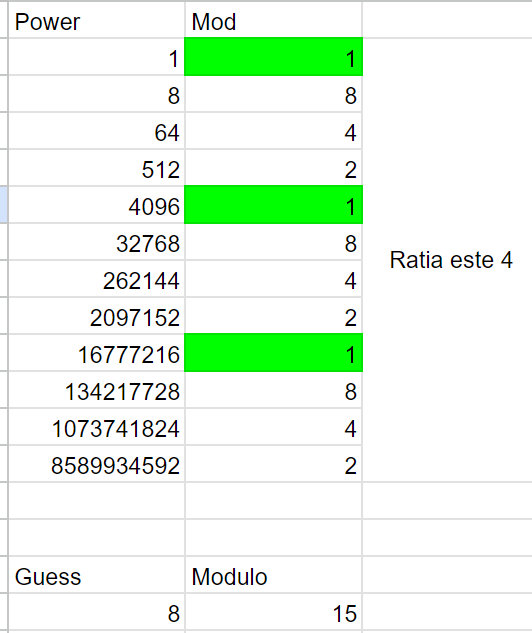

In [21]:
from qiskit_aer import Aer
from qiskit_aer.primitives import Estimator
from qiskit import QuantumCircuit
from qiskit.visualization import plot_histogram
from qiskit import transpile
import numpy as np
from fractions import Fraction

# definim un gate pentru multiplicare in modulo 15
def c_amod15(a, p):

    if gcd(a, N) != 1:
      print(f"{a} nu este prim cu 15, am gasit deja factorii lui 15")
      return;

    # acest circuit pe 4 biti efectueaza *a de p ori
    # https://www.youtube.com/watch?v=vFsEe_XbR3o&ab_channel=Elucyda
    U = QuantumCircuit(4)
    for _iteration in range(p):
        if a in [2,13]:
            U.swap(2,3)
            U.swap(1,2)
            U.swap(0,1)
        if a in [7, 8]:
            U.swap(0,1)
            U.swap(1,2)
            U.swap(2,3)
        if a in [4, 11]:
            U.swap(1,3)
            U.swap(0,2)
        if a in [7,11,13]:
            for q in range(4):
                U.x(q)
        # exemplu

    U = U.to_gate()
    U.name = f"{a}^{p} mod 15"
    c_U = U.control()
    return c_U

# functia pentru quantum fourier transfer
def qft(n):
  # mapeaza valorile din starile noastre pe
  qc = QuantumCircuit(n)
  for qubit in range(n//2):
    qc.swap(qubit, n-qubit-1)
  for j in range(n):
    for m in range(j):
      qc.cp(-np.pi/float(2**(j-m)),m,j)
    qc.h(j)
  qc.name = "QTF"
  return qc



In [27]:


N_COUNT = 8
# de ce e 2 ^ 3?
N = 15
g = 7

qc = QuantumCircuit(4+N_COUNT, N_COUNT)
for q in range(N_COUNT):
    qc.h(q)  # lista initiala de stari, valori de la 000 la 111

qc.x(N_COUNT) # starea de final
for q in range(N_COUNT): # Do controlled-U operations
    qc.append(c_amod15(g, 2**q),
              [q] + [i+N_COUNT for i in range(4)])

qc.append(qft(N_COUNT), range(N_COUNT)) # inverse-QFT
qc.measure(range(N_COUNT), range(N_COUNT))

# Simulate Results
aer_sim = Aer.get_backend('aer_simulator')

job = aer_sim.run(transpile(qc, aer_sim), shots=1, memory=True)
readings = job.result().get_memory()
#

print("Register Reading: " + readings[0])
phase = int(readings[0],2)/(2**N_COUNT)
print(f"Corresponding Phase: {phase}")

Register Reading: 11000000
Corresponding Phase: 0.75


In [29]:
r = Fraction(phase).limit_denominator(15).denominator

print(f"r = {r}")
guesses = [gcd(g**(r//2)-1, N), gcd(g**(r//2)+1, N)]
print(guesses)

r = 4
[3, 5]
